## Import the data

In [1]:
import os
import pandas as pd

# combine files
input_files = [
    os.path.join(os.getcwd(), "..", "data", "QQQ.csv"),
    os.path.join(os.getcwd(), "..", "data", "SPY.csv"),
]
X = None  # type: pd.DataFrame

for f in input_files:
    if X is None:
        X = pd.read_csv(f)
    else:
        X = X.append(pd.read_csv(f))

print(f"Data Tail:\n{X.tail(10)}")
print(f"Data shape: {X.shape}")
print(f"Data info:\n{X.info()}")

%store X

Data Tail:
     TARGET  EOM  SMA32_CD  SMA64_CD  MIN_MAX_MID  RESLP32  BB20_CDP  RESLP6  \
6752      =  0.6       0.4       0.9          0.9      0.9       0.3     0.9   
6753      =  0.6       0.5       0.9          0.9      0.9       0.4     0.9   
6754      =  0.6       0.6       0.9          0.9      0.9       0.6     0.9   
6755      =  0.6       0.6       0.9          0.9      0.9       0.8     0.9   
6756      =  0.5       0.7       0.9          0.9      0.9       0.9     0.9   
6757      =  0.6       0.8       0.9          0.9      0.9       0.9     0.9   
6758      =  0.5       0.8       0.9          0.9      0.9       0.9     0.9   
6759      =  0.5       0.9       0.9          0.9      0.9       0.9     0.8   
6760      =  0.5       0.8       0.9          0.7      0.7       0.9     0.1   
6761      =  0.5       0.7       0.9          0.7      0.7       0.9     0.1   

      RSIV32  SQZ  ...  REGP6+  REGP32+  SMA6+  SMA32+  SMA64+  EOM+  MID+  \
6752     0.6    0  ...       0

## Run the ml model


<PrefetchDataset shapes: ((None, 124, 30), (None, 5)), types: (tf.float64, tf.uint8)>
<PrefetchDataset shapes: ((None, 124, 30), (None, 5)), types: (tf.float64, tf.uint8)>
<PrefetchDataset shapes: ((None, 124, 30), (None, 5)), types: (tf.float64, tf.uint8)>
<PrefetchDataset shapes: ((None, 124, 30), (None, 5)), types: (tf.float64, tf.uint8)>
Index(['+', '++', '-', '--', '='], dtype='object')
<PrefetchDataset shapes: ((None, 124, 30), (None, 5)), types: (tf.float64, tf.uint8)>
Epoch 1/30
795/795 [==============================] - 8s 10ms/step - loss: 1.1650 - accuracy: 0.4748 - val_loss: 0.9896 - val_accuracy: 0.5207

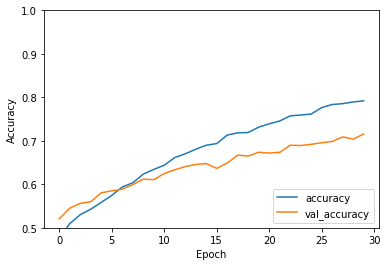

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

SHUFFLER_BUFFER_SIZE = 1024
BATCH_SIZE = 10
WINDOW_SIZE = 124
AUTOTUNE = tf.data.experimental.AUTOTUNE
NUM_COLUMNS = 30
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

def create_overlapping(df, steps=10):
    """
    Create overlapping 3d array with a given pandas dataframe X
    :type df: pd.DataFrame
    :param steps:
    :rtype: np.ndarray
    """
    data = None
    for i in range(steps, len(df)):
        if data is None:
            data = np.array([df.iloc[i-steps:i].values])
        else:
            data = np.append(data, [df.iloc[i-steps:i].values], axis=0)
    return data

def test_train_split(x, percent_in_test = 10):
    """
    Taken from: https://stackoverflow.com/questions/51125266/how-do-i-split-tensorflow-datasets/58452268#58452268
    :type x: tf.data.Dataset
    :rtype: tuple
    """
    def is_test(x, y):
        return x % percent_in_test == 0

    def is_train(x, y):
        return not is_test(x, y)

    recover = lambda x,y: y
    x_test = x.enumerate().filter(is_test).map(recover)
    x_train = x.enumerate().filter(is_train).map(recover)
    return x_test, x_train

def create_dataset(x, labels, is_training=True):
    # create the dataset
    ds = tf.data.Dataset.from_tensor_slices((x, labels))
    if is_training is True:
        ds = ds.cache().shuffle(SHUFFLER_BUFFER_SIZE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def split_test_train_dataframe(df):
    """
    :param df:
    :type df: pd.DataFrame
    :return:
    """
    df.dropna(inplace=True)
    labels = pd.get_dummies(df.pop("TARGET")[WINDOW_SIZE:]) # type: pd.DataFrame
    label_names = labels.columns
    # one hot encode the labels
    x_train, x_test, lables_train, labels_test = train_test_split(
        create_overlapping(df, WINDOW_SIZE),
        labels,
        test_size=0.33,
        random_state=False)
    return (create_dataset(x_train, lables_train, True),
            create_dataset(x_test, labels_test,  False), label_names)

def evaluate_model(train_ds, validate_ds, epochs=10):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(128, 3, activation='relu', input_shape=(WINDOW_SIZE, NUM_COLUMNS), name='conv_1'),
        tf.keras.layers.Conv1D(128, 3, activation='relu', name='conv_2'),
        tf.keras.layers.Dropout(0.5, name='dropout_1'),
        tf.keras.layers.MaxPooling1D(pool_size=2, name='pooling_1'),
        tf.keras.layers.Flatten(name='flatten'),
        tf.keras.layers.Dense(100, activation='relu', name='dense_1'),
        tf.keras.layers.Dense(5, activation='softmax', name='output')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    history = model.fit(train_ds, epochs=epochs, validation_data=validate_ds)
    _, accuracy = model.evaluate(train_ds)
    return history, accuracy

X_train, X_test, labels = split_test_train_dataframe(X)

print(X_train)
print(X_test)
print(X_train)
print(X_test)
print(labels)
print(X_train)
history, accuracy = evaluate_model(X_train, X_test, EPOCHS)
print(f"final accuracy: {accuracy}")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')